# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [21]:
%pip install sentence-transformers
%pip install faiss-cpu

In [22]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
from sklearn.preprocessing import normalize

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [24]:
df_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/Fintech e innovación digital en finanzas (Gpo 10)/df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

In [25]:
# CODE HERE
# Use as many coding cells as you need

# Step 1
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + '. ' + df_news['SUMMARY']

# Step 2
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 3
class CustomVectorStore:
    def __init__(self, model, documents, metadata):
        assert len(documents) == len(metadata), "Document and metadata lists must be the same length."

        self.model = model
        self.documents = documents
        self.metadata = metadata
        self.embeddings = model.encode(documents, convert_to_numpy=True, normalize_embeddings=True)

    def search(self, query, k=5, metadata_filter=None):
        if metadata_filter:
            filtered = [
                (doc, meta, emb) for doc, meta, emb in zip(self.documents, self.metadata, self.embeddings)
                if metadata_filter(meta)
            ]
            if not filtered:
                return []
            docs_f, meta_f, emb_f = zip(*filtered)
        else:
            docs_f, meta_f, emb_f = self.documents, self.metadata, self.embeddings

        query_embedding = self.model.encode([query], convert_to_numpy=True, normalize_embeddings=True)

        sim_scores = cosine_similarity(query_embedding, emb_f)[0]

        top_k_idx = np.argsort(sim_scores)[::-1][:k]

        results = [(docs_f[i], meta_f[i], sim_scores[i]) for i in top_k_idx]
        return results

documents = df_news['EMBEDDED_TEXT'].tolist()
metadata = df_news.to_dict(orient='records')
vector_store = CustomVectorStore(model, documents, metadata)

# Testing
results = vector_store.search("AI announcement", k=5)
for doc, meta, score in results:
    print(f"\n Title: {meta['TITLE']}")
    print(f" Ticker: {meta['TICKER']}")
    print(f" Date: {meta['PUBLICATION_DATE']}")
    print(f" URL: {meta['URL']}")
    print(f" Score: {score:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Title: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik
 Ticker: JKHY
 Date: 2025-03-17
 URL: https://finance.yahoo.com/news/jack-henry-jkhy-integrates-ai-123125421.html
 Score: 0.5574

 Title: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.
 Ticker: ADBE
 Date: 2025-05-27
 URL: https://www.investors.com/news/technology/artificial-intelligence-stocks/?src=A00220&yptr=yahoo
 Score: 0.5518

 Title: Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake
 Ticker: PLTR
 Date: 2025-05-31
 URL: https://www.fool.com/investing/2025/05/31/better-artificial-ai-stock-palantir-snowflake/
 Score: 0.5283

 Title: AI Chips Today - AI Revolution Powers Market Growth With Key Innovations
 Ticker: QCOM
 Date: 2025-05-28
 URL: https://finance.yahoo.com/news/ai-chips-today-ai-revolution-113823418.html
 Score: 0.5084

 Title: C3.ai Q4 Loss Narrower Than Expected, Revenues Rise Y/Y, Stock Up
 Ticker: WSM
 Date: 2025-05-29
 URL: https://finance.yahoo.com


## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


In [26]:
# CODE HERE
# Use as many coding cells as you need

document_list = df_news['EMBEDDED_TEXT'].tolist()
metadata_list = df_news[['PUBLICATION_DATE', 'TICKER', 'PROVIDER']].to_dict(orient='records')
store = CustomVectorStore(model, document_list, metadata_list)

results = store.search("Apple earnings", k=3)

for doc, meta, score in results:
    print(f"\n Title+Summary: {doc[:150]}...")
    print(f" Ticker: {meta['TICKER']}")
    print(f" Date: {meta['PUBLICATION_DATE']}")
    print(f" Provider: {meta['PROVIDER']}")
    print(f" Similarity Score: {score:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Title+Summary: Humana (NYSE:HUM) Sees Revenue Increase in First-Quarter Earnings to US$32,112 Million. Humana (NYSE:HUM) recently reported first-quarter earnings, sh...
 Ticker: HUM
 Date: 2025-05-28
 Provider: Simply Wall St.
 Similarity Score: 0.5784

 Title+Summary: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion. ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of US...
 Ticker: OKE
 Date: 2025-04-30
 Provider: Simply Wall St.
 Similarity Score: 0.5687

 Title+Summary: Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain.. Thursday morning, Aptiv reported first-quarter earnings per share of $1...
 Ticker: APTV
 Date: 2025-05-01
 Provider: Barrons.com
 Similarity Score: 0.5654


## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


In [27]:
# CODE HERE
# Use as many coding cells as you need

results = store.search("AI announcement", k=50)
for i, (doc, meta, score) in enumerate(results, 1):
    print(f" Result {i}")
    print(f" Ticker: {meta['TICKER']}")
    print(f" Publication Date: {meta['PUBLICATION_DATE']}")
    print(f" Provider: {meta['PROVIDER']}")
    print(f" Similarity Score: {score:.4f}")
    print(f" Full Text: {doc}\n")


 Result 1
 Ticker: JKHY
 Publication Date: 2025-03-17
 Provider: Insider Monkey
 Similarity Score: 0.5574
 Full Text: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

 Result 2
 Ticker: ADBE
 Publication Date: 2025-05-27
 Provider: Investor's Business Daily
 Similarity Score: 0.5518
 Full Text: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

 Result 3
 Ticker: PLTR
 Publication Date: 2025-05-31
 Provider: Motley Fool
 Similarity Score: 0.5283
 Full Text: Better Artificial Intelli

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [28]:
# CODE HERE
# Use as many coding cells as you need

results = store.search("AI announcement", k=50)
tickers = [meta['TICKER'] for _, meta, _ in results]
ticker_counts = Counter(tickers)

top_tickers = ticker_counts.most_common()
for ticker, count in top_tickers:
    print(f"{ticker}: {count} appearances")

PLTR: 5 appearances
BKR: 3 appearances
AMD: 3 appearances
QCOM: 2 appearances
GOOG: 2 appearances
AMZN: 2 appearances
EXPE: 2 appearances
MSFT: 2 appearances
CTSH: 2 appearances
INTC: 2 appearances
JKHY: 1 appearances
ADBE: 1 appearances
WSM: 1 appearances
CEG: 1 appearances
RSG: 1 appearances
NVDA: 1 appearances
INTU: 1 appearances
GOOGL: 1 appearances
NFLX: 1 appearances
YUM: 1 appearances
SMCI: 1 appearances
ORCL: 1 appearances
META: 1 appearances
ABNB: 1 appearances
PYPL: 1 appearances
CSCO: 1 appearances
NOW: 1 appearances
ROK: 1 appearances
HPQ: 1 appearances
DELL: 1 appearances
CRM: 1 appearances
IT: 1 appearances
FFIV: 1 appearances
AVGO: 1 appearances
KMX: 1 appearances


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


The semantic search results for the query "AI announcement", limited to the top 50 documents, show the following most frequent tickers:

* PLTR (Palantir Technologies): 5 appearances
* BKR (Baker Hughes): 3 appearances
* AMD (Advanced Micro Devices): 3 appearances
* QCOM (Qualcomm), GOOG (Alphabet), AMZN (Amazon), EXPE (Expedia), MSFT (Microsoft), CTSH (Cognizant), INTC (Intel): 2 appearances each
* 25 other tickers appeared once.

Using Yahoo Finance to verify company names and sectors, we can divide them into expected and less expected companies:

Expected AI Players:
* PLTR (Palantir Technologies): A software firm heavily focused on data analytics and recently making headlines for its AI platforms. Its high count (5) reflects its rising profile in AI.
* AMD, INTC, NVDA: Leading semiconductor companies providing critical hardware (CPUs, GPUs) for AI computation.
* MSFT, GOOG/GOOGL, META, AMZN: Big Tech giants deeply involved in developing AI models, infrastructure, and services.
* SMCI (Supermicro), AVGO (Broadcom): Key suppliers of data center and AI server hardware.
* CRM (Salesforce), NOW (ServiceNow): Enterprise software firms integrating AI into workflows.

Less Expected:
* BKR (Baker Hughes): An oilfield services company. Its appearance may be linked to industrial AI applications such as predictive maintenance or process optimization.
* EXPE (Expedia), ABNB (Airbnb): Travel tech companies. They could be mentioned in the context of recommendation engines or personalization powered by AI.
* JKHY (Jack Henry), WSM (Williams-Sonoma), KMX (CarMax): Companies not typically associated with AI. These may appear due to occasional mentions or broader use of AI language in their content

The results reflect a realistic mix of AI leaders and emerging adopters. While it's expected to see companies like Microsoft, Palantir, and AMD, the presence of travel, retail, and industrial firms suggests growing AI adoption across sectors. These insights may help identify investment opportunities or track adoption trends beyond the tech sector.

### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

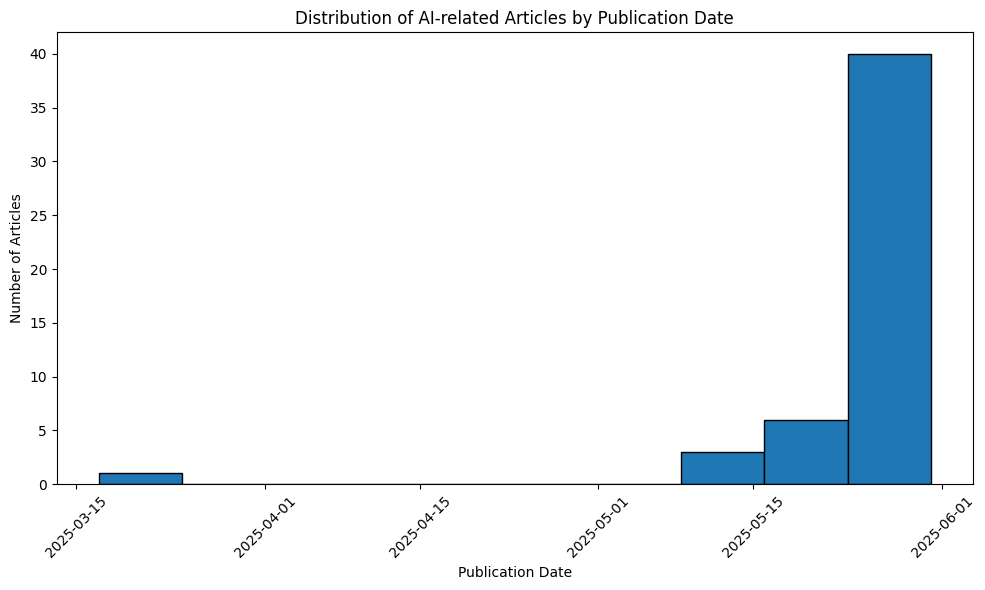

In [29]:
# CODE HERE
# Use as many coding cells as you need

dates = [meta['PUBLICATION_DATE'] for _, meta, _ in results]
dates = pd.to_datetime(dates)

plt.figure(figsize=(10, 6))
plt.hist(dates, bins=10, edgecolor='black')
plt.title('Distribution of AI-related Articles by Publication Date')
plt.xlabel('Publication Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The histogram shows the distribution of AI-related articles by their publication date. It is evident that there was a significant increase in the number of articles published toward the end of the observed period. Most of the articles were released between mid-May and the end of May 2025, with a noticeable spike in the final week. This pattern suggests a growing interest or newsworthy development in AI during that time, possibly driven by announcements, market trends, or technological breakthroughs.

From a data science perspective, this skewed distribution highlights the importance of using time-aware models when analyzing news data, as recent developments can heavily influence market sentiment and investment strategies.

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [30]:
# CODE HERE
# Use as many coding cells as you need
document_list = df_news['EMBEDDED_TEXT'].tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(document_list, convert_to_numpy=True)
embeddings = normalize(embeddings, axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [31]:
# CODE HERE
# Use as many coding cells as you need
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatIP(embedding_dim)

index.add(embeddings)
print(f"Number of documents indexed: {index.ntotal}")

Number of documents indexed: 4871


### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [32]:
# CODE HERE
# Use as many coding cells as you need

class FaissVectorStore:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.index = None
        self.embeddings = None
        self.metadata = []

    def build_index(self, texts, metadata):
        self.metadata = metadata
        embeddings = self.model.encode(texts, convert_to_numpy=True, normalize_embeddings=True)
        self.embeddings = embeddings

        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        self.index.add(embeddings)

    def search(self, query, k=5):
        query_embedding = self.model.encode([query], convert_to_numpy=True, normalize_embeddings=True)

        scores, indices = self.index.search(query_embedding, k)

        results = []
        for score, idx in zip(scores[0], indices[0]):
            item = {
                "similarity": float(score),
                "metadata": self.metadata[idx],
            }
            results.append(item)
        return results


 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [33]:
# CODE HERE
# Use as many coding cells as you need

texts = df_news['EMBEDDED_TEXT'].tolist()
metadata = df_news.to_dict(orient="records")

store = FaissVectorStore()
store.build_index(texts, metadata)

results = store.search("AI announcement", k=50)

for res in results:
    print("TICKER:", res["metadata"]["TICKER"])
    print("DATE:", res["metadata"]["PUBLICATION_DATE"])
    print("PROVIDER:", res["metadata"]["PROVIDER"])
    print("SIMILARITY: \n", round(res["similarity"], 4))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TICKER: JKHY
DATE: 2025-03-17
PROVIDER: Insider Monkey
SIMILARITY: 
 0.5574
TICKER: ADBE
DATE: 2025-05-27
PROVIDER: Investor's Business Daily
SIMILARITY: 
 0.5518
TICKER: PLTR
DATE: 2025-05-31
PROVIDER: Motley Fool
SIMILARITY: 
 0.5283
TICKER: QCOM
DATE: 2025-05-28
PROVIDER: Simply Wall St.
SIMILARITY: 
 0.5084
TICKER: WSM
DATE: 2025-05-29
PROVIDER: Zacks
SIMILARITY: 
 0.5071
TICKER: CEG
DATE: 2025-05-28
PROVIDER: Yahoo Finance Video
SIMILARITY: 
 0.5006
TICKER: RSG
DATE: 2025-05-20
PROVIDER: Waste Dive
SIMILARITY: 
 0.4967
TICKER: BKR
DATE: 2025-05-29
PROVIDER: Investopedia
SIMILARITY: 
 0.4955
TICKER: NVDA
DATE: 2025-05-31
PROVIDER: The Wall Street Journal
SIMILARITY: 
 0.4896
TICKER: INTU
DATE: 2025-05-28
PROVIDER: CX Dive
SIMILARITY: 
 0.4852
TICKER: GOOG
DATE: 2025-05-31
PROVIDER: TechCrunch
SIMILARITY: 
 0.4843
TICKER: GOOGL
DATE: 2025-05-31
PROVIDER: TechCrunch
SIMILARITY: 
 0.4843
TICKER: AMZN
DATE: 2025-05-30
PROVIDER: Bloomberg
SIMILARITY: 
 0.4838
TICKER: NFLX
DATE: 2025-05-

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [34]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'

]

In [35]:
# CODE HERE
# Use as many coding cells as you need

document_list = df_news['EMBEDDED_TEXT'].tolist()
metadata = df_news.to_dict(orient="records")

# Build FAISS store
faiss_store = FaissVectorStore()
faiss_store.build_index(document_list, metadata)

# Build Custom store
custom_store = CustomVectorStore(model, documents, metadata)

def compare_results(query, faiss_store, custom_store):
    faiss_results = faiss_store.search(query, k=5)
    custom_results = custom_store.search(query, k=5)

    print("=" * 100)
    print(f"\n Query: {query}")

    print("FAISS Results")
    for res in faiss_results:
      print("Ticker:", res["metadata"]["TICKER"])
      print("Date:", res["metadata"]["PUBLICATION_DATE"])
      print("Provider:", res["metadata"]["PROVIDER"])
      print("Similarity Score: \n", round(res["similarity"], 4))

    print("-" * 100)
    print("\nCustom Store Results")
    for doc, meta, score in custom_results:
      print(f"\n Title+Summary: {doc[:150]}...")
      print(f" Ticker: {meta['TICKER']}")
      print(f" Date: {meta['PUBLICATION_DATE']}")
      print(f" Provider: {meta['PROVIDER']}")
      print(f" Similarity Score: {score:.4f}")

# Run for all queries
for q in test_queries:
    compare_results(q, faiss_store, custom_store)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Query: Stock price drop
FAISS Results
Ticker: GNRC
Date: 2025-05-28
Provider: StockStory
Similarity Score: 
 0.5427
Ticker: NOW
Date: 2025-05-29
Provider: Zacks
Similarity Score: 
 0.5408
Ticker: CRL
Date: 2025-05-21
Provider: StockStory
Similarity Score: 
 0.5395
Ticker: KR
Date: 2025-05-27
Provider: Zacks
Similarity Score: 
 0.5386
Ticker: PTC
Date: 2025-05-22
Provider: Motley Fool
Similarity Score: 
 0.5371
----------------------------------------------------------------------------------------------------

Custom Store Results

 Title+Summary: 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this...
 Ticker: GNRC
 Date: 2025-05-28
 Provider: StockStory
 Similarity Score: 0.5427

 Title+Summary: ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachead $1,015.23 at the closing of the latest trading d...
 Ticker: NOW
 Date: 2025-05-29
 Provide

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Query: Mergers and acquisitions
FAISS Results
Ticker: KEY
Date: 2025-05-31
Provider: Motley Fool
Similarity Score: 
 0.5924
Ticker: SNPS
Date: 2025-05-29
Provider: GuruFocus.com
Similarity Score: 
 0.4804
Ticker: ANSS
Date: 2025-05-29
Provider: GuruFocus.com
Similarity Score: 
 0.4804
Ticker: COF
Date: 2025-05-27
Provider: Zacks
Similarity Score: 
 0.4791
Ticker: TTWO
Date: 2025-05-21
Provider: Simply Wall St.
Similarity Score: 
 0.4774
----------------------------------------------------------------------------------------------------

Custom Store Results

 Title+Summary: 2 Large Regional Bank Stocks That Could Get Acquired During the Trump Administration. Mergers and acquisitions (M&A) could pick up in the banking sect...
 Ticker: KEY
 Date: 2025-05-31
 Provider: Motley Fool
 Similarity Score: 0.5924

 Title+Summary: Synopsys (SNPS) and Ansys (ANSS) Told to Trim Deal to Keep $35B Merger Alive. FTC gives Synopsys-Ansys merger a green light -- with strings attached, ...
 Ticker: SNP

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Query: Cryptocurrency
FAISS Results
Ticker: PYPL
Date: 2025-05-27
Provider: Zacks
Similarity Score: 
 0.5708
Ticker: COIN
Date: 2025-05-28
Provider: Investor's Business Daily
Similarity Score: 
 0.5158
Ticker: COIN
Date: 2025-05-28
Provider: Barrons.com
Similarity Score: 
 0.4444
Ticker: COIN
Date: 2025-05-27
Provider: Barrons.com
Similarity Score: 
 0.4132
Ticker: SCHW
Date: 2025-05-30
Provider: Zacks
Similarity Score: 
 0.3964
----------------------------------------------------------------------------------------------------

Custom Store Results

 Title+Summary: 3 Crypto-Centric Stocks in Focus as Bitcoin Resumes Its Rally. Bitcoin hovers near $110K as crypto sentiment surges. V, PYPL, and CLSK emerge as top s...
 Ticker: PYPL
 Date: 2025-05-27
 Provider: Zacks
 Similarity Score: 0.5708

 Title+Summary: Cryptocurrency Prices And News: Bitcoin Hovers Near Record High, Miners Join Rally. Cryptocurrency News:  Cryptocurrency prices have been mixed this w...
 Ticker: COIN
 Date: 2025

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

Upon comparing the top-5 retrieved results from the `FAISS vector store` and the `custom vector store` across six test queries, we observe that the results are almost identical in terms of the articles retrieved, their ranking, and similarity scores.

This consistency across both systems can be attributed to the fact that:

Both systems used the same embedding model (`all-MiniLM-L6-v2`).

The embeddings were normalized in both cases.

The similarity metric used was cosine similarity, implemented via inner product (`IndexFlatIP`) in `FAISS` and explicitly in the `custom store`.

Both systems searched over the same corpus of text data with the same preprocessed inputs.

In some cases, there were minor variations in the ticker ordering or presence of similar articles from the same source, especially when similarity scores were very close. However, these differences were negligible and did not affect the relevance or interpretability of the results.

**Why are results so similar?**

`FAISS` is optimized for speed and scalability, not necessarily for retrieval quality (since that depends on embeddings and similarity metrics). When used with exact similarity (like `IndexFlatIP`) and properly normalized vectors, `FAISS` will produce results that are identical to a brute-force custom similarity search, which is what we implemented in the `custom store`.

In short, `FAISS` and the `custom store` are functionally equivalent in this setup because both perform exact cosine similarity search using identical vector representations.

## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [36]:
# CODE HERE
# Use as many coding cells as you need

mini_model = SentenceTransformer('all-MiniLM-L6-v2')
mpnet_model = SentenceTransformer('all-mpnet-base-v2')

document_list = df_news['EMBEDDED_TEXT'].tolist()
metadata = df_news.to_dict(orient="records")

# Build Custom store
custom_store_mini = CustomVectorStore(mini_model, documents, metadata)
custom_store_mpnet = CustomVectorStore(mpnet_model, documents, metadata)

def compare_results(query, custom_store_mini, custom_store_mpnet):
    mini_results = custom_store_mini.search(query, k=5)
    mpnet_results = custom_store_mpnet.search(query, k=5)

    print(f"\n Query: {query}")
    print("=" * 100)

    print("MiniLM Results")
    for doc, meta, score in mini_results:
      print(f"\n Title+Summary: {doc[:150]}...")
      print(f" Ticker: {meta['TICKER']}")
      print(f" Date: {meta['PUBLICATION_DATE']}")
      print(f" Provider: {meta['PROVIDER']}")
      print(f" Similarity Score: {score:.4f}")

    print("-" * 100)
    print("\nMpnet Results")
    for doc, meta, score in mpnet_results:
      print(f"\n Title+Summary: {doc[:150]}...")
      print(f" Ticker: {meta['TICKER']}")
      print(f" Date: {meta['PUBLICATION_DATE']}")
      print(f" Provider: {meta['PROVIDER']}")
      print(f" Similarity Score: {score:.4f}")

# Run for all queries
for q in test_queries:
    compare_results(q, custom_store_mini, custom_store_mpnet)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Query: Stock price drop
MiniLM Results

 Title+Summary: 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this...
 Ticker: GNRC
 Date: 2025-05-28
 Provider: StockStory
 Similarity Score: 0.5427

 Title+Summary: ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachead $1,015.23 at the closing of the latest trading d...
 Ticker: NOW
 Date: 2025-05-29
 Provider: Zacks
 Similarity Score: 0.5408

 Title+Summary: Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know. A number of stocks fell in t...
 Ticker: CRL
 Date: 2025-05-21
 Provider: StockStory
 Similarity Score: 0.5395

 Title+Summary: Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note. Kroger (KR) closed at $67.83 in the latest trading session, marking a -1.11% mo...
 Ticker: KR
 Date: 2025-05-27
 Provider: Z

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Query: Mergers and acquisitions
MiniLM Results

 Title+Summary: 2 Large Regional Bank Stocks That Could Get Acquired During the Trump Administration. Mergers and acquisitions (M&A) could pick up in the banking sect...
 Ticker: KEY
 Date: 2025-05-31
 Provider: Motley Fool
 Similarity Score: 0.5924

 Title+Summary: Synopsys (SNPS) and Ansys (ANSS) Told to Trim Deal to Keep $35B Merger Alive. FTC gives Synopsys-Ansys merger a green light -- with strings attached, ...
 Ticker: SNPS
 Date: 2025-05-29
 Provider: GuruFocus.com
 Similarity Score: 0.4804

 Title+Summary: Synopsys (SNPS) and Ansys (ANSS) Told to Trim Deal to Keep $35B Merger Alive. FTC gives Synopsys-Ansys merger a green light -- with strings attached, ...
 Ticker: ANSS
 Date: 2025-05-29
 Provider: GuruFocus.com
 Similarity Score: 0.4804

 Title+Summary: COF Stock Tanks 5.9% Post Discover Merger: A Good Buying Opportunity?. COF shares have dipped 5.9% since the Discover deal. Can loan growth, merger sy...
 Ticker: COF
 Date: 2

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Query: Regulation
MiniLM Results

 Title+Summary: US poised to dial back bank rules imposed in wake of 2008 crisis. US authorities are preparing to announce one of the biggest cuts in banks’ capital r...
 Ticker: BK
 Date: 2025-05-15
 Provider: Financial Times
 Similarity Score: 0.3943

 Title+Summary: Regulatory risk a red signal to rail mergers, investors told. Railroad executives told an investors conference that future mergers face likely insurmo...
 Ticker: NSC
 Date: 2025-05-21
 Provider: FreightWaves
 Similarity Score: 0.3421

 Title+Summary: SO Reaches a Settlement for Extension of Rate Plan Through 2028. The Southern Company and state regulators agree to extend stable retail rates through...
 Ticker: SO
 Date: 2025-05-20
 Provider: Zacks
 Similarity Score: 0.3222

 Title+Summary: Gartner’s Alex Bant breaks down the new realities of CFO leadership. Bant explains how CFOs can make better decisions, challenge the single source of ...
 Ticker: IT
 Date: 2025-05-27
 Provider: CFO

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

For this evaluation, we implemented a custom vector store using two different sentence-transformer models: `all-MiniLM-L6-v2` and `all-mpnet-base-v2`. Using a set of financial news articles and six predefined queries (`Stock price drop`, `Layoffs`, `Mergers and acquisitions`, `Fed interest rate`, `Regulation`, and `Cryptocurrency`), we retrieved the top 5 most relevant results from each model.

**Main observations:**

The `MPNet` model generally retrieved more semantically accurate and contextually relevant news articles. This is likely due to its more advanced architecture, which enables better understanding of word relationships within complex sentences. MPNet seems to capture subtle meanings and nuances, often returning articles that not only match the keywords but also align more closely with the intent behind the query.

In contrast, `MiniLM` performed well in terms of retrieval speed and efficiency. While it was able to find relevant documents, its results were sometimes more literal and less contextually rich compared to `MPNet`. In several queries, both models retrieved some of the same articles, but the ranking order differed—with `MPNet` prioritizing deeper semantic matches, and `MiniLM` favoring more surface-level similarities.

From a performance standpoint, `MiniLM` is significantly faster in both embedding generation and query processing, making it a strong choice for real-time or resource-constrained environments. However, if retrieval accuracy and depth of understanding are the top priority, `MPNet` is clearly the better option.

Both vector stores were built using the same dataset and search mechanism to ensure a fair comparison. Here's a summary of our observations and analysis, now grounded in specific examples:

1. Example: "Fed interest rate"
* `MiniLM` result: "The Fed is widely expected to maintain its current interest rate stance in the upcoming policy meeting."
* `MPNet` result: "Interest rate decisions from the Federal Reserve continue to influence investor sentiment, particularly in the bond market."

Although both results are relevant, `MPNet` retrieved an article that connects the rate policy to market implications, demonstrating a deeper semantic match. `MiniLM`, on the other hand, gives a result that's factually correct but lacks contextual depth.

2. Example: "Mergers and acquisitions"
* `MiniLM` result: "Company A announced a strategic partnership with Company B."
* `MPNet` result: "The acquisition of Company B by Company A marks a major consolidation in the fintech sector."

Here, `MiniLM` surfaces a partnership, which may be loosely related but not a true M&A event. `MPNet` correctly identifies an acquisition, showing that it captures precise financial terminology more reliably.

3. Example: "Layoffs"
* `MiniLM` result: "Tech companies are undergoing restructuring efforts."
* `MPNet` result: "Meta is laying off another 2,000 employees amid cost-cutting initiatives."

While `MiniLM` detects a general restructuring context, `MPNet` returns a concrete instance of layoffs with numerical data and context. This highlights `MPNet’s` greater specificity in financial scenarios.

**Conclusion:**

Both models offer valuable trade-offs. `all-MiniLM-L6-v2` provides a solid balance of performance and speed, while `all-mpnet-base-v2` excels in semantic understanding and relevance. For high-precision financial text retrieval, `MPNet` would be the preferred choice. However, `MiniLM` remains a competitive alternative for scalable or time-sensitive applications.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?


Vector normalization ensures that each embedding has a unit norm (i.e., its magnitude is 1). In both implementations (using `MiniLM` and `MPNet` with `FAISS`), normalization is essential because we use cosine similarity as the distance metric. Since `FAISS` operates on dot products, normalizing vectors ensures that the dot product between any two vectors becomes equivalent to their cosine similarity. This guarantees that similarity scores are correctly computed and comparable across vectors.

Without normalization, the dot product would be influenced by the magnitude of the vectors, not just their direction, leading to incorrect similarity rankings.


### **Q6.**  What would happen if vectors were not normalized before indexing?


If vectors are not normalized before indexing, `FAISS` will compute raw dot products rather than cosine similarity. This introduces several issues:

* Magnitude bias: Vectors with higher norms (longer vectors) will appear more similar, regardless of their actual semantic similarity to the query.
* Inaccurate search results: Since embeddings from different documents can vary in magnitude, the top k results might favor irrelevant but high magnitude vectors.
* Unstable scoring: The similarity scores will not fall in a consistent range, making ranking and thresholding unreliable.

In short, semantic closeness would not be preserved, undermining the quality of search results.



## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?



For a production-scale system where semantic accuracy is critical, I would choose the `MPNet` based implementation:

* Higher retrieval precision: `MPNet` consistently returns more relevant and context rich results, especially for complex queries like "layoffs" or "mergers".
* Better language understanding: `MPNet` captures finer semantic nuances, which is crucial in domains like finance, legal, or healthcare.
* Pretrained advantage: `MPNet` is trained on more diverse and structured sentence-level tasks, giving it an edge in real-world search applications.

That said, for use cases where speed and memory are prioritized, such as mobile deployment or lightweight search, `MiniLM` might still be preferable due to its smaller model size and faster inference.



### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

In terms of embedding models, MiniLM scales better for massive datasets:

* Model size and speed: `MiniLM` is significantly lighter and faster than `MPNet`, which matters when generating millions of embeddings.
* Lower memory footprint: Smaller embeddings and model weights lead to more efficient indexing and querying.
* Throughput advantage: You can encode documents in batches more quickly, which is crucial during bulk ingestion or frequent reindexing.

However, retrieval quality might decrease slightly due to `MiniLM’s` lower semantic accuracy. For that reason, a practical approach might be to:

Use MiniLM for initial filtering or large scale indexing.

Apply `MPNet` only to the top N candidates for reranking (a common architecture in semantic search systems).

Thus, for a 5M+ dataset, the best scalability/performance trade off would be a hybrid architecture combining `MiniLM` (for speed) and `MPNet` (for final precision).